In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from networkx.drawing.nx_pydot import write_dot
from networkx.linalg.graphmatrix import *
from networkx.algorithms.approximation import *
#from networkx.centrality import closn
from networkx.algorithms import *
import gc
gc.collect()


21

In [2]:
input = pd.read_csv("/home/abhishek/Graph/titanic.csv")

In [3]:
# drop un-used column
del input['Name']
del input['ID']  
del input['Survived']

In [4]:
total_rows=len(input.axes[0])
total_cols=len(input.axes[1])
print("Number of Rows: "+str(total_rows))
print("Number of Columns: "+str(total_cols))
print("Max of connection in graph: "+str(total_rows*total_cols))
input.describe()

Number of Rows: 887
Number of Columns: 6
Max of connection in graph: 5322


,Pclass,Age,Sib_Spou,Parent_Child,Fare
count,887.000000,887.000000,887.000000,887.000000,887.00000
mean,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.836662,14.121908,1.104669,0.807466,49.78204
min,1.000000,0.420000,0.000000,0.000000,0.00000
25%,2.000000,20.250000,0.000000,0.000000,7.92500
50%,3.000000,28.000000,0.000000,0.000000,14.45420
75%,3.000000,38.000000,1.000000,0.000000,31.13750
max,3.000000,80.000000,8.000000,6.000000,512.32920


In [5]:
#input(input)
input.head(5) 

,Pclass,Sex,Age,Sib_Spou,Parent_Child,Fare
0,3,male,22.0,1,0,7.2500
1,1,female,38.0,1,0,71.2833
2,3,female,26.0,0,0,7.9250
3,1,female,35.0,1,0,53.1000
4,3,male,35.0,0,0,8.0500


In [6]:
#input = Survived_0
input.shape

(887, 6)

In [7]:
input['Age_prect_10'] = pd.qcut(input['Age'], q=4)
input['Age_prect_level'] = pd.qcut(input['Age'], q=4, labels=(1,2,3,4))

input['Fare_prect_10'] = pd.qcut(input['Fare'], q=4)
input['Fare_prect_level'] = pd.qcut(input['Fare'], q=4, labels=(1,2,3,4))

input.loc[input['Sex'] == 'male', 'sex'] = '1'
input.loc[input['Sex'] == 'female', 'sex'] = '0'
#input.head(5)

In [8]:
#drop un-use column
del input['Fare']
del input['Age'] 
del input['Age_prect_10'] 
del input['Fare_prect_10'] 
del input['Sex'] 
input.head(5)

,Pclass,Sib_Spou,Parent_Child,Age_prect_level,Fare_prect_level,sex
0,3,1,0,2,1,1
1,1,1,0,3,4,0
2,3,0,0,2,1,0
3,1,1,0,3,4,0
4,3,0,0,3,2,1


In [9]:
input.columns

Index(['Pclass', 'Sib_Spou', 'Parent_Child', 'Age_prect_level',
       'Fare_prect_level', 'sex'],
      dtype='object')

In [10]:
def create_graph_data(input):
    another_input_list = []
    count = 0
    for i in range(len(input.axes[1])-1): #range(len(input.axes[1])-1)
        if len(input.axes[1]) > i :
            current_col = input.axes[1][i]
            next_col = input.axes[1][i+1]

            for j in range(len(input.axes[0])):
                item = str(input.axes[1][i])+'_'+str(input[current_col][j]),str(input.axes[1][i+1])+'_'+str(input[next_col][j]),input[next_col][j]
                another_input_list.append(item)
                count = count + j
            #
            #print(next_col,len(input.axes[1]),i,j)
        else:
            print("end")

    #print('number of combination of edge (%d)' % (count))
    
    return another_input_list

In [11]:
def graph_create(another_input_list):
    
    MG_1 = nx.DiGraph()
    MG_1.add_weighted_edges_from(another_input_list)
    pos = nx.nx_agraph.graphviz_layout(MG_1)
    nx.draw(MG_1, pos=pos,with_labels=True,node_color='r', edge_color='b',
            fontsize=1,width = 0.4, alpha = 0.7, scale = 10)
    plt.axis("Off")
    plt.show()
    print(MG_1.nodes())
    print('Number of edges',MG_1.number_of_edges())
    print('Number of Nodes',MG_1.number_of_nodes())
    return MG_1

# this code will print nice graph

In [12]:
#### this code will print nice graph
#MG_1 = graph_create(another_input_list)
#nx.nx_agraph.view_pygraphviz(MG_1)

In [13]:
def column_arrange (col_name,edge_impotance_order):
    col_name = list(col_name)
    temp = list(edge_impotance_order)[0].rpartition('_')[0]
    print('High ranked column ---->',temp)
    #print('\nOld column name order\n',col_name)
    col_name.remove(temp)
    col_name.insert(0,temp)
    #print('\nNew column name order\n',col_name)
    
    return list(col_name),temp
    #edge_impotance_order.keys()
    #google_PGR_O = google_matrix(MG_1, alpha=0.9)
    #google_PGR_O

In [14]:
def variable_imp (another_input_list):
    
    ################
    # approach-1    
    ################
    print("\nDiGraph")
    MG_1 = graph_create(another_input_list)
    edge_impotance_weight = {}
    edge_impotance_order = {}
    W=MG_1.edges.data('weight', default=1)
    count = 1
    while (MG_1.number_of_nodes() > 0):
        '''
        pos = nx.nx_agraph.graphviz_layout(MG_1)
        nx.draw(MG_1, pos=pos,with_labels=True,node_color='r', edge_color='b',
            fontsize=1,width = 0.4, alpha = 0.7, scale = 10)
        plt.axis("Off")
        plt.show()
        '''
        PGR_O = nx.pagerank(MG_1, alpha=0.90,max_iter=100, weight=W) 
        # , nstart=W this could be the start value of each node
        #type(PGR_O)
        #print(max(PGR_O.keys()))
        #print(round(max(PGR_O.values()),5))  # maximum rank of the node

        for key, value in PGR_O.items():
            if round(value,5) == round(max(PGR_O.values()),5):
                #print('Edge name -> ',key, '->', round(value,5))
                edge_impotance_weight.update({key:round(value,5)})
                edge_impotance_order.update({key:count})
                MG_1.remove_node(key)
                count = count + 1
                #print('Number of edge',MG_1.number_of_edges(key))

    return edge_impotance_weight,edge_impotance_order

# Run one time with default order of column

In [15]:
# Run one time with default order of column
col_name = input.columns
input = input.reindex(columns=col_name)
input.head(5)
#another_input_list = create_graph_data(input)
#another_input_list[0:5]

,Pclass,Sib_Spou,Parent_Child,Age_prect_level,Fare_prect_level,sex
0,3,1,0,2,1,1
1,1,1,0,3,4,0
2,3,0,0,2,1,0
3,1,1,0,3,4,0
4,3,0,0,3,2,1


In [16]:
#another_input_list = create_graph_data(input)

# create graph and node important for data set
#edge_impotance_weight,edge_impotance_order = variable_imp(another_input_list)


DiGraph


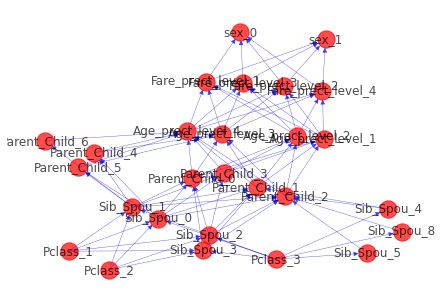

['Pclass_3', 'Sib_Spou_1', 'Pclass_1', 'Sib_Spou_0', 'Sib_Spou_3', 'Pclass_2', 'Sib_Spou_4', 'Sib_Spou_2', 'Sib_Spou_5', 'Sib_Spou_8', 'Parent_Child_0', 'Parent_Child_1', 'Parent_Child_2', 'Parent_Child_5', 'Parent_Child_3', 'Parent_Child_4', 'Parent_Child_6', 'Age_prect_level_2', 'Age_prect_level_3', 'Age_prect_level_4', 'Age_prect_level_1', 'Fare_prect_level_1', 'Fare_prect_level_4', 'Fare_prect_level_2', 'Fare_prect_level_3', 'sex_1', 'sex_0']
Number of edges 83
Number of Nodes 27
{'sex_1': 1, 'sex_0': 2, 'Age_prect_level_4': 3, 'Age_prect_level_3': 4, 'Age_prect_level_2': 5, 'Age_prect_level_1': 6, 'Parent_Child_2': 7, 'Parent_Child_1': 8, 'Parent_Child_0': 9, 'Parent_Child_3': 10, 'Parent_Child_5': 11, 'Parent_Child_4': 12, 'Parent_Child_6': 13, 'Sib_Spou_1': 14, 'Sib_Spou_0': 15, 'Sib_Spou_3': 16, 'Sib_Spou_2': 17, 'Sib_Spou_4': 18, 'Sib_Spou_5': 19, 'Sib_Spou_8': 20, 'Pclass_3': 21, 'Pclass_1': 22, 'Pclass_2': 23, 'Fare_prect_level_1': 24, 'Fare_prect_level_4': 25, 'Fare_prect_l

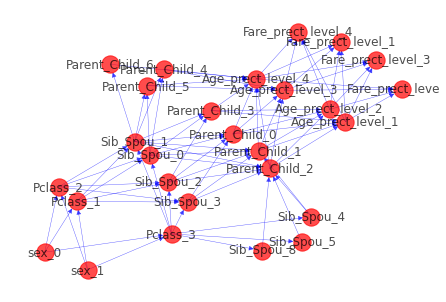

['sex_1', 'Pclass_3', 'sex_0', 'Pclass_1', 'Pclass_2', 'Sib_Spou_1', 'Sib_Spou_0', 'Sib_Spou_3', 'Sib_Spou_4', 'Sib_Spou_2', 'Sib_Spou_5', 'Sib_Spou_8', 'Parent_Child_0', 'Parent_Child_1', 'Parent_Child_2', 'Parent_Child_5', 'Parent_Child_3', 'Parent_Child_4', 'Parent_Child_6', 'Age_prect_level_2', 'Age_prect_level_3', 'Age_prect_level_4', 'Age_prect_level_1', 'Fare_prect_level_1', 'Fare_prect_level_4', 'Fare_prect_level_2', 'Fare_prect_level_3']
Number of edges 81
Number of Nodes 27
{'Age_prect_level_4': 1, 'Age_prect_level_3': 2, 'Age_prect_level_2': 3, 'Age_prect_level_1': 4, 'Parent_Child_2': 5, 'Parent_Child_1': 6, 'Parent_Child_0': 7, 'Parent_Child_3': 8, 'Parent_Child_5': 9, 'Parent_Child_4': 10, 'Parent_Child_6': 11, 'Sib_Spou_1': 12, 'Sib_Spou_0': 13, 'Sib_Spou_3': 14, 'Sib_Spou_2': 15, 'Pclass_3': 16, 'Pclass_1': 17, 'Pclass_2': 18, 'sex_1': 19, 'sex_0': 20, 'Sib_Spou_4': 21, 'Sib_Spou_5': 22, 'Sib_Spou_8': 23, 'Fare_prect_level_1': 24, 'Fare_prect_level_4': 25, 'Fare_prect_l

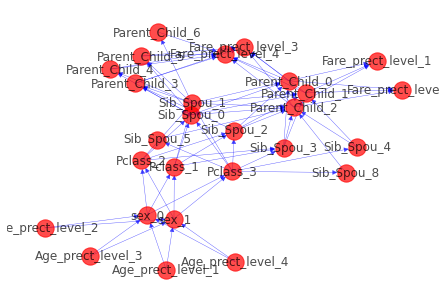

['Age_prect_level_2', 'sex_1', 'Age_prect_level_3', 'sex_0', 'Age_prect_level_4', 'Age_prect_level_1', 'Pclass_3', 'Pclass_1', 'Pclass_2', 'Sib_Spou_1', 'Sib_Spou_0', 'Sib_Spou_3', 'Sib_Spou_4', 'Sib_Spou_2', 'Sib_Spou_5', 'Sib_Spou_8', 'Parent_Child_0', 'Parent_Child_1', 'Parent_Child_2', 'Parent_Child_5', 'Parent_Child_3', 'Parent_Child_4', 'Parent_Child_6', 'Fare_prect_level_1', 'Fare_prect_level_4', 'Fare_prect_level_2', 'Fare_prect_level_3']
Number of edges 72
Number of Nodes 27
{'Fare_prect_level_4': 1, 'Fare_prect_level_3': 2, 'Fare_prect_level_1': 3, 'Fare_prect_level_2': 4, 'Parent_Child_2': 5, 'Parent_Child_1': 6, 'Parent_Child_0': 7, 'Parent_Child_3': 8, 'Parent_Child_5': 9, 'Parent_Child_4': 10, 'Parent_Child_6': 11, 'sex_1': 12, 'sex_0': 13, 'Sib_Spou_1': 14, 'Sib_Spou_0': 15, 'Sib_Spou_3': 16, 'Sib_Spou_2': 17, 'Sib_Spou_4': 18, 'Sib_Spou_5': 19, 'Sib_Spou_8': 20, 'Age_prect_level_2': 21, 'Age_prect_level_3': 22, 'Age_prect_level_4': 23, 'Age_prect_level_1': 24, 'Pclass_3

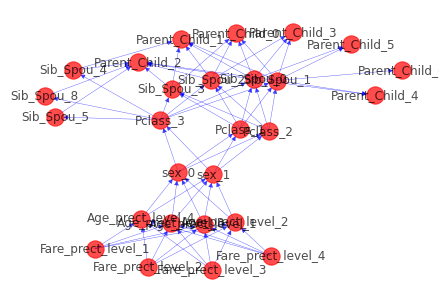

['Fare_prect_level_1', 'Age_prect_level_2', 'Fare_prect_level_4', 'Age_prect_level_3', 'Fare_prect_level_2', 'Age_prect_level_4', 'Fare_prect_level_3', 'Age_prect_level_1', 'sex_1', 'sex_0', 'Pclass_3', 'Pclass_1', 'Pclass_2', 'Sib_Spou_1', 'Sib_Spou_0', 'Sib_Spou_3', 'Sib_Spou_4', 'Sib_Spou_2', 'Sib_Spou_5', 'Sib_Spou_8', 'Parent_Child_0', 'Parent_Child_1', 'Parent_Child_2', 'Parent_Child_5', 'Parent_Child_3', 'Parent_Child_4', 'Parent_Child_6']
Number of edges 69
Number of Nodes 27
{'Parent_Child_2': 1, 'Parent_Child_1': 2, 'Parent_Child_0': 3, 'Parent_Child_3': 4, 'sex_1': 5, 'sex_0': 6, 'Parent_Child_5': 7, 'Parent_Child_4': 8, 'Parent_Child_6': 9, 'Age_prect_level_2': 10, 'Age_prect_level_3': 11, 'Age_prect_level_4': 12, 'Age_prect_level_1': 13, 'Sib_Spou_1': 14, 'Sib_Spou_0': 15, 'Sib_Spou_3': 16, 'Sib_Spou_2': 17, 'Sib_Spou_4': 18, 'Sib_Spou_5': 19, 'Sib_Spou_8': 20, 'Fare_prect_level_1': 21, 'Fare_prect_level_4': 22, 'Fare_prect_level_2': 23, 'Fare_prect_level_3': 24, 'Pclass_3

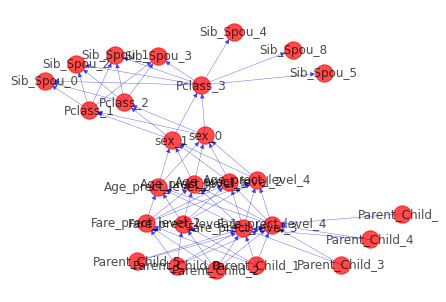

['Parent_Child_0', 'Fare_prect_level_1', 'Fare_prect_level_4', 'Fare_prect_level_2', 'Parent_Child_1', 'Fare_prect_level_3', 'Parent_Child_2', 'Parent_Child_5', 'Parent_Child_3', 'Parent_Child_4', 'Parent_Child_6', 'Age_prect_level_2', 'Age_prect_level_3', 'Age_prect_level_4', 'Age_prect_level_1', 'sex_1', 'sex_0', 'Pclass_3', 'Pclass_1', 'Pclass_2', 'Sib_Spou_1', 'Sib_Spou_0', 'Sib_Spou_3', 'Sib_Spou_4', 'Sib_Spou_2', 'Sib_Spou_5', 'Sib_Spou_8']
Number of edges 64
Number of Nodes 27
{'sex_1': 1, 'sex_0': 2, 'Fare_prect_level_4': 3, 'Fare_prect_level_3': 4, 'Fare_prect_level_1': 5, 'Fare_prect_level_2': 6, 'Sib_Spou_1': 7, 'Sib_Spou_0': 8, 'Sib_Spou_3': 9, 'Sib_Spou_2': 10, 'Sib_Spou_4': 11, 'Sib_Spou_5': 12, 'Sib_Spou_8': 13, 'Parent_Child_0': 14, 'Parent_Child_1': 15, 'Parent_Child_2': 16, 'Parent_Child_5': 17, 'Parent_Child_3': 18, 'Parent_Child_4': 19, 'Parent_Child_6': 20, 'Age_prect_level_2': 21, 'Age_prect_level_3': 22, 'Age_prect_level_4': 23, 'Age_prect_level_1': 24, 'Pclass_3

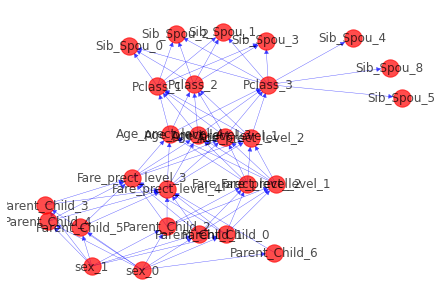

['sex_1', 'Parent_Child_0', 'sex_0', 'Parent_Child_1', 'Parent_Child_2', 'Parent_Child_5', 'Parent_Child_3', 'Parent_Child_4', 'Parent_Child_6', 'Fare_prect_level_1', 'Fare_prect_level_4', 'Fare_prect_level_2', 'Fare_prect_level_3', 'Age_prect_level_2', 'Age_prect_level_3', 'Age_prect_level_4', 'Age_prect_level_1', 'Pclass_3', 'Pclass_1', 'Pclass_2', 'Sib_Spou_1', 'Sib_Spou_0', 'Sib_Spou_3', 'Sib_Spou_4', 'Sib_Spou_2', 'Sib_Spou_5', 'Sib_Spou_8']
Number of edges 75
Number of Nodes 27
{'Pclass_3': 1, 'Pclass_1': 2, 'Pclass_2': 3, 'Fare_prect_level_4': 4, 'Fare_prect_level_3': 5, 'Fare_prect_level_1': 6, 'Fare_prect_level_2': 7, 'Parent_Child_0': 8, 'Parent_Child_1': 9, 'Parent_Child_2': 10, 'Parent_Child_5': 11, 'Parent_Child_3': 12, 'Parent_Child_4': 13, 'Parent_Child_6': 14, 'sex_1': 15, 'sex_0': 16, 'Age_prect_level_2': 17, 'Age_prect_level_3': 18, 'Age_prect_level_4': 19, 'Age_prect_level_1': 20, 'Sib_Spou_1': 21, 'Sib_Spou_0': 22, 'Sib_Spou_3': 23, 'Sib_Spou_4': 24, 'Sib_Spou_2': 2

In [17]:
col_count = 0
imp_attribute = []
edge_impotance_order_final = {}
while (col_count < len(input.columns)):
    # create graph dataset
    another_input_list = create_graph_data(input)

    # create graph and node important for data set
    edge_impotance_weight,edge_impotance_order = variable_imp(another_input_list)
    print(edge_impotance_order)
    # make important node as primary node
    col_name,imp = column_arrange(col_name,edge_impotance_order)
    
    imp_attribute.append(imp)
    
    edge_impotance_order_final.update({col_count:edge_impotance_weight})

    #arrange the data set as per new order
    input = input.reindex(columns=col_name)
    #input.head(5)
    col_count = col_count + 1
    #print(col_count)

In [18]:
imp_attribute

['sex', 'Age_prect_level', 'Fare_prect_level', 'Parent_Child', 'sex', 'Pclass']

In [19]:
#edge_impotance_order_final

In [20]:
test = pd.DataFrame(edge_impotance_order_final)
type(test)

pandas.core.frame.DataFrame

In [21]:
test.shape

(27, 6)

In [82]:
# convert the index into column
    #test.reset_index(level=0, inplace=True)
    #test["attribute_name"] = test.index
test

,0,1,2,3,4,5,col_name
sex_1,0.11640,0.11111,0.08784,0.07774,0.08601,0.07692,
sex_0,0.11640,0.11111,0.08784,0.07774,0.08601,0.07692,
Age_prect_level_4,0.09165,0.08583,0.14286,0.07819,0.07143,0.07692,
Age_prect_level_3,0.10397,0.09735,0.14286,0.07819,0.07143,0.07692,
Age_prect_level_2,0.11116,0.10429,0.14286,0.07819,0.07143,0.07692,
Age_prect_level_1,0.11116,0.10429,0.14286,0.07819,0.07143,0.07692,
Parent_Child_2,0.14825,0.13382,0.11753,0.09666,0.07143,0.05865,
Parent_Child_1,0.12656,0.11525,0.10286,0.08512,0.07143,0.05865,
Parent_Child_0,0.13769,0.12861,0.11890,0.10026,0.07143,0.05865,
Parent_Child_3,0.13018,0.11955,0.10838,0.08961,0.07143,0.05865,


In [83]:
len(test.index)
test['col_name'][0]

''

In [84]:
#list(test.index).rpartition('_')[0]
#(list(test.index)[3]).find('_')  #rpartition('_')
test['col_name'] = ''
for i in range(len(test.index)):
    test['col_name'][i] = test.index[i].rpartition('_')[0]

<ipython-input-84-e32af04910a0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['col_name'][i] = test.index[i].rpartition('_')[0]


In [94]:
test['min_of_iteration']= test.min(axis=1)

In [1]:
#test

In [104]:
final = pd.DataFrame(test.groupby(['col_name'])['min_of_iteration'].agg('sum'))

In [108]:
final.sort_values('min_of_iteration')

,min_of_iteration
col_name,
sex,0.15384
Pclass,0.21429
Age_prect_level,0.28572
Fare_prect_level,0.34586
Parent_Child,0.42333
Sib_Spou,0.48433


In [25]:
#pd.DataFrame(test.groupby('Age_prect_level_4').size().head(10))

In [26]:
test.to_csv('/home/abhishek/Graph/2_titanic_output.csv', sep=',', encoding='utf-8')